In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import models
from keras import layers
from keras.models import Model
from pickle import dump
from keras.layers import Dense
from keras.layers import Flatten
from keras import losses 
from keras import optimizers 
from keras import metrics 
import os
import zipfile
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# 1.  unzipped file

In [2]:

zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [3]:
print(os.listdir('../input/dogs-vs-cats'))

['test1.zip', 'train.zip', 'sampleSubmission.csv']


# 2.prepare data

In [4]:
IMAGE_FOLDER_PATH="../working/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

In [5]:
targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

In [6]:
dataset.head(10)

,image_path,target
0,../working/train/cat.11063.jpg,cat
1,../working/train/cat.4114.jpg,cat
2,../working/train/cat.10308.jpg,cat
3,../working/train/cat.10945.jpg,cat
4,../working/train/dog.4963.jpg,dog
5,../working/train/dog.6677.jpg,dog
6,../working/train/dog.5194.jpg,dog
7,../working/train/cat.4220.jpg,cat
8,../working/train/dog.6700.jpg,dog
9,../working/train/cat.317.jpg,cat


# 3. image processing

In [7]:
dataset_train, dataset_test=train_test_split(dataset,
                                                 test_size=0.2,
                                                 random_state=42)

In [8]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

In [9]:
train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


# 4.transfer learning (features extraction)

In [11]:
predictmodel = VGG16(include_top=False, input_shape=(150, 150, 3),weights ='imagenet')
predictmodel.summary()

2022-04-08 13:39:37.297679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:39:37.404459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:39:37.405342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:39:37.406627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [12]:
for layer in predictmodel.layers:
    layer.trainable = False

In [13]:
# add new classifier layers
flat1 = Flatten()(predictmodel.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)

# define new model
predictmodel = Model(inputs=predictmodel.inputs, outputs=output)
# summarize
predictmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# 5. compile & train model.

In [14]:
predictmodel.compile(loss = 'binary_crossentropy',  
   optimizer = 'rmsprop', metrics=["accuracy"])

In [15]:
modelHistory=predictmodel.fit(train_datagenerator,
                                epochs=20,
                                validation_data=test_datagenerator,
                                validation_steps=20,
                                steps_per_epoch=20
                                )

2022-04-08 13:39:43.179366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-04-08 13:39:45.860184: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 45s 2s/step - loss: 1.9294 - accuracy: 0.6407 - val_loss: 0.7688 - val_accuracy: 0.6663
Epoch 2/20
20/20 [==============================] - 32s 2s/step - loss: 0.5740 - accuracy: 0.7283 - val_loss: 0.3990 - val_accuracy: 0.8110
Epoch 3/20
20/20 [==============================] - 32s 2s/step - loss: 0.4776 - accuracy: 0.7603 - val_loss: 0.5703 - val_accuracy: 0.7207
Epoch 4/20
20/20 [==============================] - 32s 2s/step - loss: 0.4294 - accuracy: 0.7976 - val_loss: 0.3206 - val_accuracy: 0.8540
Epoch 5/20
20/20 [==============================] - 32s 2s/step - loss: 0.4337 - accuracy: 0.8020 - val_loss: 0.3857 - val_accuracy: 0.8170
Epoch 6/20
20/20 [==============================] - 32s 2s/step - loss: 0.4362 - accuracy: 0.7887 - val_loss: 0.2625 - val_accuracy: 0.8937
Epoch 7/20
20/20 [==============================] - 32s 2s/step - loss: 0.3758 - accuracy: 0.8250 - val_loss: 0.3809 - val_accuracy: 0.8123
Epoch 8/20
20/20 [=============

# 6.plot accuracy.

In [16]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validatin Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validatin Accuracy"]=modelHistory.history['val_accuracy']
  
    history.plot(figsize=(12,8))
    plt.title(" Convulutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

Train Accuracy:0.870
Test Accuracy:0.904


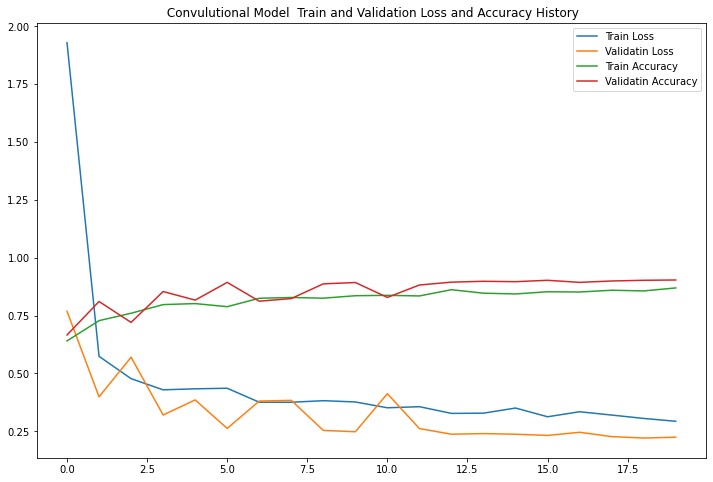

In [17]:
print("Train Accuracy:{:.3f}".format(modelHistory.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(modelHistory.history['val_accuracy'][-1]))
show_model_history(modelHistory=modelHistory, model_name="")

# 5.create model from scratch.

In [18]:
model=models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        3

In [19]:
model.compile(loss = 'binary_crossentropy',  
   optimizer = 'rmsprop', metrics=["accuracy"])

In [20]:
modelHistory1=model.fit(train_datagenerator,
                                epochs=20,
                                validation_data=test_datagenerator,
                                validation_steps=20,
                                steps_per_epoch=20
                                )

Epoch 1/20
20/20 [==============================] - 34s 2s/step - loss: 1.8881 - accuracy: 0.5550 - val_loss: 0.6950 - val_accuracy: 0.5183
Epoch 2/20
20/20 [==============================] - 31s 2s/step - loss: 0.8480 - accuracy: 0.5713 - val_loss: 0.7598 - val_accuracy: 0.4960
Epoch 3/20
20/20 [==============================] - 31s 2s/step - loss: 0.7549 - accuracy: 0.5683 - val_loss: 0.7365 - val_accuracy: 0.4943
Epoch 4/20
20/20 [==============================] - 31s 2s/step - loss: 0.7061 - accuracy: 0.5860 - val_loss: 0.7256 - val_accuracy: 0.4990
Epoch 5/20
20/20 [==============================] - 31s 2s/step - loss: 0.6888 - accuracy: 0.5990 - val_loss: 0.6909 - val_accuracy: 0.5243
Epoch 6/20
20/20 [==============================] - 32s 2s/step - loss: 0.6612 - accuracy: 0.6217 - val_loss: 0.7254 - val_accuracy: 0.5000
Epoch 7/20
20/20 [==============================] - 32s 2s/step - loss: 0.6585 - accuracy: 0.6337 - val_loss: 0.8596 - val_accuracy: 0.4980
Epoch 8/20
20/20 [==

Train Accuracy:0.769
Test Accuracy:0.577


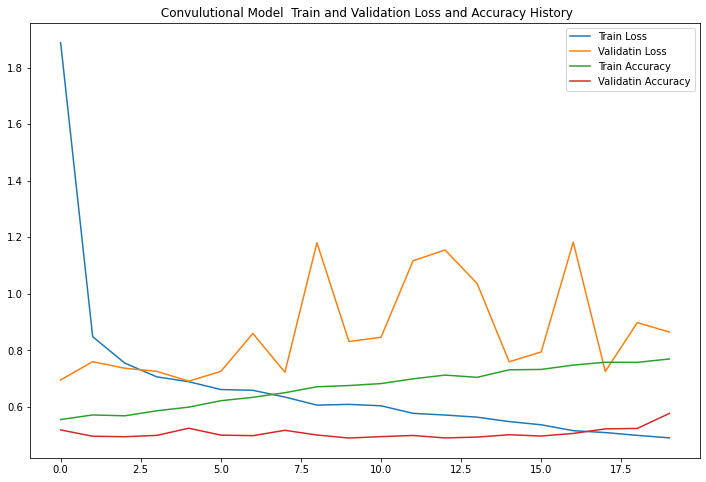

In [21]:
print("Train Accuracy:{:.3f}".format(modelHistory1.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(modelHistory1.history['val_accuracy'][-1]))
show_model_history(modelHistory=modelHistory1, model_name="")